In [2]:
%load_ext autoreload
%autoreload 2
import emcee
import corner
import pickle
import numpy as np
import pandas as pd

from astropy import units as u
from astropy import constants as const
from astropy.table import QTable
from matplotlib import pyplot as plt
from scipy.optimize import root, brentq
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp

from load_mcxc_data import load_clusters
from cluster_functions import c
from statistics_functions import chi_squared
from equilibrium_functions import equil
from cluster import Cluster

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
clusters=load_clusters(nrows=10)

In [59]:
def load_clusters1(nrows=None, dataset='REFLEX'):
    skipfooter=0 if nrows else 1
    mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=skipfooter)
    mcxccls.columns=mcxccls.columns.str.strip()

    selected_cls=mcxccls[mcxccls['Sub-Cat'].str.strip()==dataset]


    cls_data={'M500':selected_cls['M500'],
          'L500':selected_cls['L500'],
          'R500':selected_cls['R500']
         }
    units={
        'M500': 1e14*u.Msun,
        'L500': 1e37*u.W,
        'R500':u.Mpc
    }

    cls_table=QTable(cls_data, units=units)
    
    with open ('data/'+dataset+'.p', 'rb') as fp:
        L_uncertainties=np.array(pickle.load(fp))
    L_uncertainties_conv=(L_uncertainties*1e37*u.W).to(u.erg / u.s).value
    
    return [ 
        Cluster(
            cls_table['R500'][i],
            cls_table['M500'][i],
            L500=cls_table['L500'][i],
            m500=cls_table['M500'][i],
        )
        for i in range(nrows)#(mcxccls.shape[0])
    ], [variance(cls_table['L500'][i], L_uncertainties_conv[i]) for i in range(nrows)] 

In [52]:
def variance1(luminosity, l_unc): # returns the variance on calculated temperature
     # TODO: TEST THIS NOW THAT I HAVE ADDED L_unc
    #logL=np.log10((luminosity.to(1e44*u.erg/u.s))/(1e44*u.erg/u.s))

    A=ufloat(2.88, 0.15)
    B=ufloat(45.06, 0.03)

    lum = luminosity.to(u.erg / u.s)
    
    lums_uf = ufloat(lum.value, l_unc)
    log_T = (unp.log10(lums_uf) - B) / A + np.log10(6)
    #T = (10**log_T * u.keV).to(u.GeV)

    T = 10**log_T * 1e-6 #divide by 10^6 to convert keV to GeV

    return T.std_dev *u.GeV #variances on T in GeV

In [4]:
#prepare MCMC
log_mp = np.log10(const.m_p.to(u.GeV, equivalencies=u.mass_energy()).value)

ndim, nwalkers = 2, 32
p0=np.zeros((nwalkers, ndim ))
log_sigma0 = np.random.uniform(low=-30, high=-15, size=nwalkers).astype(np.float128)
log_mx = np.random.uniform(low=-2, high=log_mp, size=nwalkers).astype(np.float128)
p0[:,0]=log_sigma0
p0[:,1]=log_mx
p0

array([[-26.90088609,  -1.18725593],
       [-26.18213858,  -1.07112306],
       [-25.33229278,  -1.71859898],
       [-23.17808094,  -0.30506034],
       [-27.91879477,  -1.23908434],
       [-24.52734779,  -1.20202399],
       [-25.38698401,  -0.86886655],
       [-16.51606702,  -0.10149999],
       [-23.51917695,  -0.75974982],
       [-27.15378142,  -1.28789939],
       [-26.93466402,  -1.91120072],
       [-19.8956496 ,  -0.69963577],
       [-27.4698741 ,  -0.91709338],
       [-24.60043695,  -1.95442758],
       [-28.19513987,  -1.02081467],
       [-17.02924943,  -0.60645742],
       [-27.25326808,  -0.25443622],
       [-21.88331527,  -1.95379147],
       [-15.37465829,  -0.8281405 ],
       [-27.13509355,  -0.06433984],
       [-29.4110134 ,  -0.77061756],
       [-29.55737677,  -0.25210577],
       [-22.8586876 ,  -0.62698831],
       [-20.86465464,  -1.85975238],
       [-24.38294238,  -0.21147268],
       [-21.98474455,  -0.06116785],
       [-24.51682411,  -0.40940353],
 

In [175]:
T_data = [c.baryon_temp for c in clusters]

In [176]:
def log_lik(p0, T_data, var, clusters):
    if p0[0]<-40 or p0[0]>-10:
        return -np.inf
    if p0[1]<-3 or 10**p0[1]>const.m_p.to(u.GeV, equivalencies=u.mass_energy()).value:
        return -np.inf
    #print(p0)
    T_model = [brentq(equil, -10, 0, args=(c, p0[0], p0[1])) for c in clusters]
    X2 = chi_squared(np.power(10,T_model)*u.GeV, T_data, var)
    return (-X2/2)

In [179]:
log_lik(p0[0], T_data, variances, clusters)

<Quantity -595.54121382>

In [180]:
n=0
sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim, 
    log_lik, 
    args=[T_data, variances, clusters])

In [181]:
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

100%|█████████████████████████████████████████| 100/100 [12:38<00:00,  7.58s/it]


In [188]:
sampler.run_mcmc(state, 1000, progress=True)

100%|█████████████████████████████████████| 1000/1000 [2:18:07<00:00,  8.29s/it]


State([[-22.49084497  -0.1686525 ]
 [-22.22977779  -0.15163288]
 [-22.19264108  -0.1675252 ]
 [-16.84187121  -0.13782749]
 [-22.48445046  -0.17508921]
 [-22.56659877  -0.17967831]
 [-23.88391101  -1.69312982]
 [-22.30213583  -0.14797758]
 [-22.40362073  -0.1750761 ]
 [-22.18345415  -0.14819337]
 [-22.33969774  -0.14365765]
 [-22.68408262  -0.19467654]
 [-22.59956134  -0.18732289]
 [-22.20389013  -0.14235444]
 [-21.7128228   -0.14252464]
 [-12.04064291  -0.12577094]
 [-22.33842256  -0.16452074]
 [-22.18258945  -0.1417066 ]
 [-16.8548802   -0.12901134]
 [-22.0468398   -0.15137974]
 [-22.59343095  -0.17936111]
 [-22.44848784  -0.17439826]
 [-16.76057878  -0.12065592]
 [-22.27725646  -0.1537705 ]
 [-17.08596191  -0.13529572]
 [-22.39256988  -0.1660885 ]
 [-21.93989889  -0.14335934]
 [-22.34718839  -0.17682357]
 [-22.31046716  -0.15936973]
 [-22.35737905  -0.16296862]
 [-22.69973887  -0.21538705]
 [-22.48475013  -0.18150665]], log_prob=[ -0.4824827   -0.31221894  -2.14523337  -5.23801978  -

In [209]:
sampler.run_mcmc(sampler.get_last_sample(), 2000, progress=True)

100%|█████████████████████████████████████| 2000/2000 [4:24:43<00:00,  7.94s/it]


State([[-22.33945989  -0.16917426]
 [-17.53953247  -0.11559825]
 [-22.50634079  -0.1614927 ]
 [-22.68845249  -0.18821975]
 [-22.13356452  -0.16229167]
 [-22.46525749  -0.18597195]
 [-23.91177142  -1.68735862]
 [-22.2368391   -0.1502145 ]
 [-14.55670668  -0.13083898]
 [-22.48519816  -0.18888176]
 [-14.30896948  -0.12446925]
 [-22.33174619  -0.16106806]
 [-13.9115908   -0.12334299]
 [-22.0195005   -0.14363406]
 [-19.82707241  -0.13619038]
 [-21.65643918  -0.13997557]
 [-22.32131009  -0.15505904]
 [-22.2966597   -0.15839536]
 [-22.08171952  -0.14752203]
 [-22.11528081  -0.16002394]
 [-18.18850257  -0.13007344]
 [-21.87076191  -0.14109157]
 [-10.27698486  -0.1195533 ]
 [-11.47712829  -0.13077683]
 [-22.34330542  -0.14644644]
 [-22.50727889  -0.18200497]
 [-22.59299438  -0.17536457]
 [-19.42553699  -0.13100885]
 [-22.2405329   -0.15363786]
 [-21.86455513  -0.14511596]
 [-19.7875327   -0.12263877]
 [-22.28415025  -0.15880103]], log_prob=[ -0.49641899  -4.68951975  -1.68216157  -2.5779324   -

In [210]:
samples = sampler.get_chain(flat=True)

In [211]:
"Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.483'

In [215]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 110;
tau: [224.62185831 191.72905474]

(176000, 2)


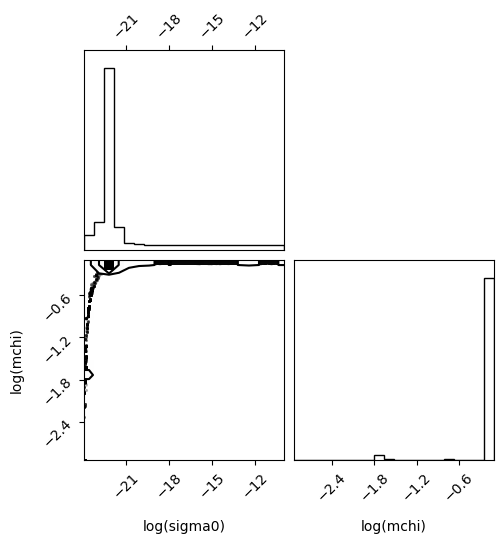

In [212]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=['log(sigma0)', 'log(mchi)'], top_ticks=True)

In [213]:
np.median(samples[:,0])

-22.21863675641677

In [214]:
np.median(samples[:,1])

-0.1526490646176092

In [172]:
np.log10(const.m_p.to(u.GeV, equivalencies=u.mass_energy()).value)

-0.027671202930545022

In [192]:
sampler.get_chain()

array([[[-18.45460095,  -0.11713932],
        [-21.43001129,  -0.13767834],
        [-19.86163032,  -0.12794656],
        ...,
        [-23.81673198,  -1.11416216],
        [-22.84262962,  -0.22963461],
        [-23.04614514,  -0.33238669]],

       [[-18.45460095,  -0.11713932],
        [-21.28143247,  -0.1374897 ],
        [-20.3236153 ,  -0.13781033],
        ...,
        [-23.81673198,  -1.11416216],
        [-22.57457025,  -0.20025226],
        [-23.04614514,  -0.33238669]],

       [[-18.66508447,  -0.13273644],
        [-21.28143247,  -0.1374897 ],
        [-20.3236153 ,  -0.13781033],
        ...,
        [-23.77819693,  -1.07281062],
        [-22.57457025,  -0.20025226],
        [-23.04614514,  -0.33238669]],

       ...,

       [[-22.49084497,  -0.1686525 ],
        [-22.22977779,  -0.15163288],
        [-22.19807228,  -0.16279908],
        ...,
        [-22.37419638,  -0.16159238],
        [-22.69973887,  -0.21538705],
        [-22.48475013,  -0.18150665]],

       [[-22.49

/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_67917/2154322017.py:9: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.scatter(np.log10(cls.baryon_temp.value),0, color='red', label='actual cluster temperature')


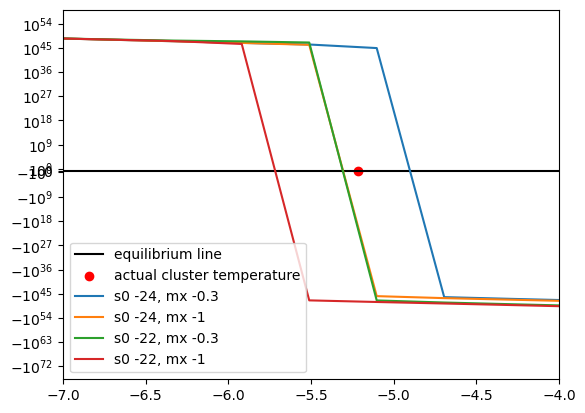

In [136]:
#troubleshoot 
log_Tbs=np.linspace(-10, 10)
cls=clusters[7]

plt.yscale('symlog')
plt.xlim(-7,-4)

plt.plot([-10,10], [0,0], color='black', label='equilibrium line')
plt.scatter(np.log10(cls.baryon_temp.value),0, color='red', label='actual cluster temperature')
plt.plot(log_Tbs, equil(log_Tbs, cls, -24, -0.3), label='s0 -24, mx -0.3')
plt.plot(log_Tbs, equil(log_Tbs, cls, -24, -1), label='s0 -24, mx -1')
plt.plot(log_Tbs, equil(log_Tbs, cls, -22, -0.3), label='s0 -22, mx -0.3')
plt.plot(log_Tbs, equil(log_Tbs, cls, -22, -1), label='s0 -22, mx -1')


plt.legend()

In [120]:
equil(log_Tbs, cls, -23.9, -1)

array([ 1.02855858e+53,  2.51179475e+52,  6.13393715e+51,  1.49794101e+51,
        3.65806134e+50,  8.93327711e+49,  2.18164768e+49,  5.32856722e+48,
        1.30195905e+48,  3.18207014e+47,  7.68270969e+46,  1.46005835e+46,
       -1.11893070e+46, -5.58519438e+46, -2.16032328e+47, -8.54705343e+47,
       -3.44794839e+48, -1.40337445e+49, -5.73292864e+49, -2.34537513e+50,
       -9.60057102e+50, -3.93078550e+51, -1.60953258e+52, -6.59075410e+52,
       -2.69883461e+53, -1.10514613e+54, -4.52547361e+54, -1.85314205e+55,
       -7.58845779e+55, -3.10740877e+56, -1.27245746e+57, -5.21060515e+57,
       -2.13369854e+58, -8.73731427e+58, -3.57785598e+59, -1.46510163e+60,
       -5.99946675e+60, -2.45673068e+61, -1.00601034e+62, -4.11952691e+62,
       -1.68691128e+63, -6.90775841e+63, -2.82866840e+64, -1.15831568e+65,
       -4.74320434e+65, -1.94230189e+66, -7.95356126e+66, -3.25691578e+67,
       -1.33367935e+68, -5.46130365e+68])

In [121]:
equil(log_Tbs, cls, -23.9, -3)

array([ 1.02855856e+53,  2.51179462e+52,  6.13393584e+51,  1.49793970e+51,
        3.65804825e+50,  8.93314598e+49,  2.18151583e+49,  5.32722994e+48,
        1.30057356e+48,  3.16696013e+47,  7.49813221e+46,  1.18150188e+46,
       -1.68545050e+46, -7.13410936e+46, -2.68148600e+47, -1.05068059e+48,
       -4.22296742e+48, -1.71636704e+49, -7.00762965e+49, -2.86623914e+50,
       -1.17316813e+51, -4.80317176e+51, -1.96672170e+52, -8.05334018e+52,
       -3.29773950e+53, -1.35039073e+54, -5.52972642e+54, -2.26437457e+55,
       -9.27241925e+55, -3.79697656e+56, -1.55482959e+57, -6.36689502e+57,
       -2.60718942e+58, -1.06762192e+59, -4.37182108e+59, -1.79022360e+60,
       -7.33081357e+60, -3.00190589e+61, -1.22925496e+62, -5.03369467e+62,
       -2.06125521e+63, -8.44066502e+63, -3.45638063e+64, -1.41535851e+65,
       -5.79577288e+65, -2.37331977e+66, -9.71854287e+66, -3.97966076e+67,
       -1.62963728e+68, -6.67322624e+68])

In [1]:
cls

NameError: name 'cls' is not defined